In [1]:
import sys
import os
import torch

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
print("Project root added to sys.path")


Project root added to sys.path


In [2]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from utils.data_loader import load_dataset
from utils.data_partition import iid_partition, non_iid_partition, dirichlet_partition, quantity_skew_partition, hybrid_partition
from clients.federated_training import federated_training
from clients.aggregators import avg_aggregate


c:\Users\la7tim\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
dataset_name = "cifar10"
trainset, testset = load_dataset(dataset_name)


Files already downloaded and verified
Files already downloaded and verified
[INFO] Loaded dataset 'cifar10' with 50000 training samples and 10000 testing samples.


In [4]:
num_clients = 5
partitions = {
    "iid": iid_partition(trainset, num_clients),
    "non_iid": non_iid_partition(trainset, num_clients=num_clients, num_shards=10),
    "dirichlet": dirichlet_partition(trainset, num_clients=num_clients, alpha=0.3),
    "quantity": quantity_skew_partition(trainset, num_clients),
    "hybrid": hybrid_partition(trainset, num_clients)
}


In [5]:
from models.tinyProp import TinyPropParams
tp_params = TinyPropParams(S_min=0.05, S_max=0.5, zeta=0.25, number_of_layers=2)


In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
rounds = 100
early_stop = 5

all_results = {}

for strategy, subsets in partitions.items():
    print(f"\n=== Federated Training with {strategy.upper()} partitions ===")
    
    try:
        global_model, acc_list, flops_list, mem_list, comm_list, sparsity_list = federated_training(
            client_datasets=subsets,
            model_name=dataset_name,
            testset=testset,
            tinyprop_params=tp_params,
            aggregator_fn=avg_aggregate,
            aggregator_kwargs=None,
            rounds=rounds,
            device=device,
            local_epochs=1,
            early_stopping_patience=early_stop,
        )
        
        all_results[strategy] = {
            "acc": acc_list,
            "flops": flops_list,
            "mem": mem_list,
            "comm": comm_list,
            "sparsity": sparsity_list
        }

    except RuntimeError as e:
        print(f"[ERROR - Skipping {strategy}] RuntimeError: {e}")
        continue



=== Federated Training with IID partitions ===

Round 1/100
Test Accuracy: 0.2921
[Compute] round_flops=1551003380.59, [Mem] peak=293440.0 bytes, [Comm] 455126432.0 bytes, [Sparsity] 99.11%

Round 2/100
Test Accuracy: 0.3894
[Compute] round_flops=1466672818.97, [Mem] peak=293440.0 bytes, [Comm] 430380472.0 bytes, [Sparsity] 93.72%

Round 3/100
Test Accuracy: 0.4069
[Compute] round_flops=1405497941.66, [Mem] peak=293396.0 bytes, [Comm] 412429316.0 bytes, [Sparsity] 89.81%

Round 4/100
Test Accuracy: 0.4283
[Compute] round_flops=1364424986.37, [Mem] peak=292968.0 bytes, [Comm] 400376868.0 bytes, [Sparsity] 87.18%

Round 5/100
Test Accuracy: 0.4451
[Compute] round_flops=1319107592.69, [Mem] peak=291136.0 bytes, [Comm] 387078932.0 bytes, [Sparsity] 84.29%

Round 6/100
Test Accuracy: 0.4669
[Compute] round_flops=1289810564.34, [Mem] peak=291540.0 bytes, [Comm] 378482012.0 bytes, [Sparsity] 82.42%

Round 7/100
Test Accuracy: 0.4696
[Compute] round_flops=1247515444.38, [Mem] peak=281752.0 by

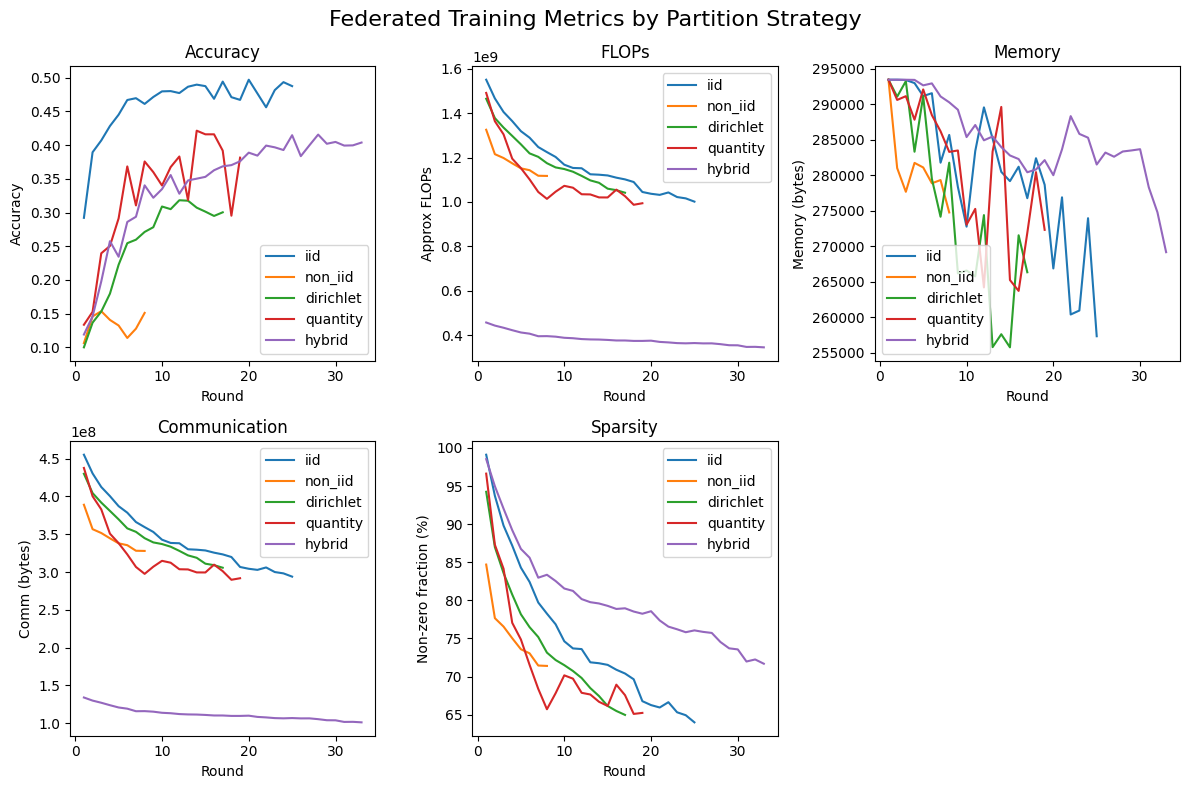

In [8]:
import matplotlib.pyplot as plt

def plot_all_partitions_in_one_figure(all_results):


    metric_keys = ["acc", "flops", "mem", "comm", "sparsity"]
    metric_titles = ["Accuracy", "FLOPs", "Memory", "Communication", "Sparsity"]
    fig, axs = plt.subplots(2, 3, figsize=(12, 8))
    fig.suptitle("Federated Training Metrics by Partition Strategy", fontsize=16)
    axs_flat = axs.ravel()

    for i, key in enumerate(metric_keys):
        ax = axs_flat[i]  
        ax.set_title(metric_titles[i])
        for strategy, data in all_results.items():
            if key not in data:
                continue 

            y_values = data[key]
            rounds_axis = range(1, len(y_values) + 1)

            if key == "sparsity":
                y_values = [val * 100 for val in y_values]
            ax.plot(rounds_axis, y_values, label=strategy)

        ax.set_xlabel("Round")
        if key == "acc":
            ax.set_ylabel("Accuracy")
        elif key == "flops":
            ax.set_ylabel("Approx FLOPs")
        elif key == "mem":
            ax.set_ylabel("Memory (bytes)")
        elif key == "comm":
            ax.set_ylabel("Comm (bytes)")
        elif key == "sparsity":
            ax.set_ylabel("Non-zero fraction (%)")

        ax.legend()

    axs_flat[-1].axis("off")

    plt.tight_layout()
    plt.show()
plot_all_partitions_in_one_figure(all_results)
